# LayerCAM可解释性分析

对单张图像，进行LayerCAM可解释性分析。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-9-21

## 导入工具包

In [1]:
from torchvision.models import vgg16, resnet50

import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入ImageNet预训练图像分类模型

In [2]:
model = vgg16(pretrained=True).eval().to(device)
# model = resnet50(pretrained=True).eval().to(device)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/azureuser/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## 图像预处理

In [3]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(224),
                                     # transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入测试图像

In [4]:
img_path = 'test_img/snake.jpg'

# img_path = 'test_img/cat_dog.jpg'

In [5]:
img_pil = Image.open(img_path)

In [8]:
# img_pil

In [6]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [10]:
input_tensor.shape

torch.Size([1, 3, 224, 334])

## 输入模型，执行前向预测

参考教程：https://www.bilibili.com/video/BV1qe4y1D7zD

In [7]:
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_tensor) 

import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [8]:
pred_softmax.shape

torch.Size([1, 1000])

## 获得图像分类预测结果

In [9]:
n = 5
top_n = torch.topk(pred_softmax, n)

In [10]:
top_n

torch.return_types.topk(
values=tensor([[0.2605, 0.2341, 0.1178, 0.1095, 0.0882]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[56, 53, 54, 60, 63]], device='cuda:0'))

In [11]:
# 解析出类别
pred_ids = top_n[1].cpu().detach().numpy().squeeze()

In [12]:
pred_ids

array([56, 53, 54, 60, 63])

In [13]:
# 解析出置信度
confs = top_n[0].cpu().detach().numpy().squeeze()

In [14]:
confs

array([0.26054516, 0.23410754, 0.11779325, 0.10946125, 0.08815183],
      dtype=float32)

In [15]:
# 载入ImageNet 1000图像分类标签
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = [row['wordnet'], row['class']]

In [16]:
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]][1] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<5} {:<15} {:>.4f}'.format(pred_ids[i], class_name, confidence)
    print(text)

56    king_snake      26.0545
53    ringneck_snake  23.4108
54    hognose_snake   11.7793
60    night_snake     10.9461
63    Indian_cobra    8.8152


## 指定分析的类别

In [17]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 如果 targets 为 None，则默认为最高置信度类别
targets = [ClassifierOutputTarget(56)]

## 分析模型结构，确定待分析的层

In [22]:
# model

## 选择可解释性分析方法

In [18]:
# LayerCAM
from pytorch_grad_cam import LayerCAM
target_layers = [model.features[8]] # vgg16
# target_layers = [model.layer3[0]] # resnet50
cam = LayerCAM(model=model, target_layers=target_layers, use_cuda=True)

## 生成CAM热力图

In [19]:
cam_map = cam(input_tensor=input_tensor, targets=targets)[0] # 不加平滑

## 可视化CAM热力图

In [25]:
cam_map.shape

(224, 334)

In [26]:
cam_map.dtype

dtype('float32')

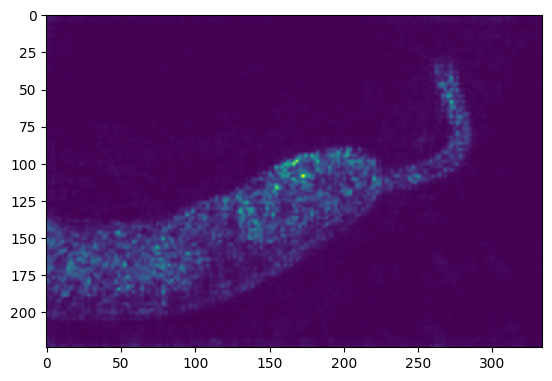

In [20]:
plt.imshow(cam_map)
plt.show()

In [21]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.12) # alpha越小，原图越淡

In [32]:
# result

In [30]:
result.save('output/B2.jpg')

## 思考题

1.更换从浅至深的不同层，观察LayerCAM的变化，效果在变得更好吗？

2.把模型换成resnet50，LayerCAM热力图会出现“棋盘网格”现象，思考原因及改进方法。

3.换一张包含多类物体的图片，查看不同层、不同类别的LayerCAM热力图，是否符合class-discriminative？

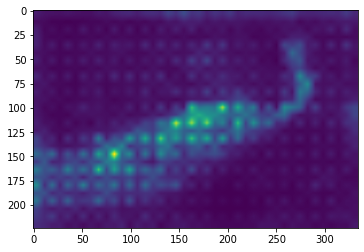

In [196]:
# 棋盘网格现象